# M5 Forecasting - Accuracy
## Estimate the unit sales of Walmart retail goods
### Бурдина Вера, Каплоухая Нина 776гр¶

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random
from itertools import cycle
import seaborn as sns

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random
from itertools import cycle
import seaborn as sns


import os
import gc
import time
import math
import datetime
import sklearn
from math import log, floor
from sklearn.neighbors import KDTree

import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.utils import shuffle
from tqdm.notebook import tqdm as tqdm

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
#import pywt
from statsmodels.robust import mad

import scipy
import statsmodels
from scipy import signal
import statsmodels.api as sm
#from fbprophet import Prophet
from scipy.signal import butter, deconvolve
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import warnings
warnings.filterwarnings("ignore")

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

%matplotlib inline


# Постановка задачи:

В данной задаче мы будем ежедневные продажи Walmart с горизонтом прогнозирования 28 дней.

Метрика прогнозирования закреплена организаторами соревнования, будем использовать ее: **Weighted RMSSE (WRMSSE)**

**Root Mean Squared Scaled Error (RMSSE):**

$$ RMSSE  = \sqrt{\frac{1}{h}\frac{\sum_{t = n + 1}^{n + h}(Y_i - \hat{Y}_i) ^ 2 }{\frac{1}{n - 1} \sum_{t=2}^{n}(Y_i - Y_{i-1}) ^ 2}},$$

где $Y_t$ - фактическое будущее значение изученного временного ряда в точке $t$, $\hat{Y}_t$  - сгенерированный прогноз, $n$ -  длина обучающей выборки (количество исторических наблюдений) и $h$ - горизонт прогнозирования.


$$ WRMSSE = \sum_{i=1}^{42840} w_i * RMSSE, $$

где $w_i$ - вес временного ряда. Чем ниже балл WRMSSE, тем лучше.

Вес каждого временного ряда будет рассчитываться на основе последних 28 наблюдений обучающей выборки набора данных, то есть совокупных фактических продаж в штуках, которые каждая серия отображала в этот конкретный период (сумма проданных единиц, умноженная на их соответствующую цену).



### Обзор доступных данных:

Датасет содержит иерархические данные о продажах Walmart, крупнейшей в мире компании по доходам. Данные охватывают магазины в трех штатах США (Калифорния, Техас и Висконсин) и включают уровень товара, отдел, категории продуктов и сведения о магазине. Кроме того, в нем есть пояснительные переменные, такие как цена, рекламные акции, день недели и специальные события. Вместе этот надежный набор данных можно использовать для повышения точности прогнозирования.

- calendar.csv - Содержит информацию о датах продажи товаров. Для каждой даты дана информацию о днях недели / недели / месяца / года, событиях и флагах, показывающих, разрешают ли магазины делать покупки с использованием продовольственных талонов SNAP. Данные есть за все даты.

- sales_train_validation.csv - Содержит исторические ежедневные данные о продажах (и характеристиках товаров) за единицу товара и магазина [d_1 - d_1913]. 

- sell_prices.csv - Содержит информацию о цене проданных товаров в магазине и дате.

- sales_train_evaluation.csv - содержит информацию о продажах [d_1 - d_1941]. То же самое, что sales_train_validation.csv + 28 дополнительных дней. Будем использовать эти 28 дней для валидации.
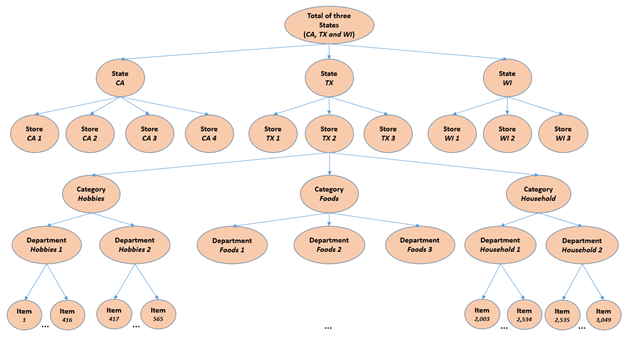

In [5]:
# Загрузка данных:

DATA_DIR = '.'
calendar_df = pd.read_csv(f'{DATA_DIR}/calendar.csv')
sales_df = pd.read_csv(f'{DATA_DIR}/sales_train_validation.csv')
sell_prices_df = pd.read_csv(f'{DATA_DIR}/sell_prices.csv')
labels_df = pd.read_csv(f'{DATA_DIR}/sales_train_evaluation.csv')

In [6]:
calendar_df.head(10)

date  wm_yr_wk    weekday  wday  month  year     d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011   d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011   d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011   d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011   d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011   d_5          NaN   
5  2011-02-03     11101   Thursday     6      2  2011   d_6          NaN   
6  2011-02-04     11101     Friday     7      2  2011   d_7          NaN   
7  2011-02-05     11102   Saturday     1      2  2011   d_8          NaN   
8  2011-02-06     11102     Sunday     2      2  2011   d_9    SuperBowl   
9  2011-02-07     11102     Monday     3      2  2011  d_10          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  
5          NaN          NaN          NaN        1        1        1  
6          NaN          NaN          NaN        1        0        0  
7          NaN          NaN          NaN        1        1        1  
8     Sporting          NaN          NaN        1        1        1  
9          NaN          NaN          NaN        1        1        0

In [45]:
sales_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [46]:
sell_prices_df.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

# Предварительный анализ данных

### Проверка пропущенных начений

Как видно явные  NaN значения присутствуют только в calendar_df. На самом деле, это не пропуск. С помощью NaN обозначаения отсутствие event1 или event2 в такой день. Информация о том, что в данный день не было свециального event тоже оцень полезна. Заменим значения NaN на значение NO_EVENT и будем использовать его как отдельное значение категорильных признаков.

In [47]:
calendar_df.isna().any(), sales_df.isna().any(), sell_prices_df.isna().any()

(date            False
 wm_yr_wk        False
 weekday         False
 wday            False
 month           False
 year            False
 d               False
 event_name_1     True
 event_type_1     True
 event_name_2     True
 event_type_2     True
 snap_CA         False
 snap_TX         False
 snap_WI         False
 dtype: bool, id          False
 item_id     False
 dept_id     False
 cat_id      False
 store_id    False
 state_id    False
 d_1         False
 d_2         False
 d_3         False
 d_4         False
 d_5         False
 d_6         False
 d_7         False
 d_8         False
 d_9         False
 d_10        False
 d_11        False
 d_12        False
 d_13        False
 d_14        False
 d_15        False
 d_16        False
 d_17        False
 d_18        False
 d_19        False
 d_20        False
 d_21        False
 d_22        False
 d_23        False
 d_24        False
             ...  
 d_1884      False
 d_1885      False
 d_1886      False
 d_1887      False


In [48]:
calendar_df[calendar_df.event_name_1.isna() == False].head()

date  wm_yr_wk    weekday  wday  month  year     d   event_name_1  \
8   2011-02-06     11102     Sunday     2      2  2011   d_9      SuperBowl   
16  2011-02-14     11103     Monday     3      2  2011  d_17  ValentinesDay   
23  2011-02-21     11104     Monday     3      2  2011  d_24  PresidentsDay   
39  2011-03-09     11106  Wednesday     5      3  2011  d_40      LentStart   
46  2011-03-16     11107  Wednesday     5      3  2011  d_47      LentWeek2   

   event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
8      Sporting          NaN          NaN        1        1        1  
16     Cultural          NaN          NaN        0        0        1  
23     National          NaN          NaN        0        0        0  
39    Religious          NaN          NaN        1        1        1  
46    Religious          NaN          NaN        0        0        0

In [49]:
calendar_df.fillna('NO_EVENT', inplace=True)

### Детальный анализ признаков

*calendar_df:*

- date, wm_yr_wk - дата, числовой или может быть преобразован к числовому
- weekday, wday - день недели, числовой или может быть преобразован к числовому (так же можно использовать категории)
- month, year, d - месяц, год, день, числовой или может быть преобразован к числовому
- event_name_1, event_name_2 - название особого мероприятия в данный день, категориальный
- event_type_1, event_type_2 - тип особого мероприятия в данный день, категориальный
- snap_CA, snap_TX, snap_WI - бинарные переменные, затрагивают ли данные event соответствующие штаты

*sales_df:*

- item_id, dept_id, cat_id - категориальные переменные, связанные с товаром, отделом, который его продает и его категорией
- store_id, state_id - категориальные переменные, связанные с магазином и штатом, в котором продается данный товар
- d_N - информация по продажам в данный день, числовой

*sell_prices_df:*

- store_id, item_id - id магазина и предмета, категориальный
- wm_yr_wk - дата, числовой или может быть преобразован к числовому
- sell_price - стоимость предмета, числовой


In [50]:
print(calendar_df.dtypes)
print('_____________________')
print(sales_df.dtypes)
print('_____________________')
print(sell_prices_df.dtypes)

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object
_____________________
id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
state_id    object
d_1          int64
d_2          int64
d_3          int64
d_4          int64
d_5          int64
d_6          int64
d_7          int64
d_8          int64
d_9          int64
d_10         int64
d_11         int64
d_12         int64
d_13         int64
d_14         int64
d_15         int64
d_16         int64
d_17         int64
d_18         int64
d_19         int64
d_20         int64
d_21         int64
d_22         int64
d_23         int64
d_24         int64
             ...  
d_1884       int64
d_1885       int64
d_1886       in

### Визуализация данных

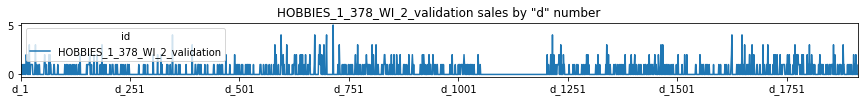

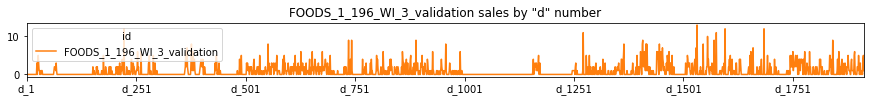

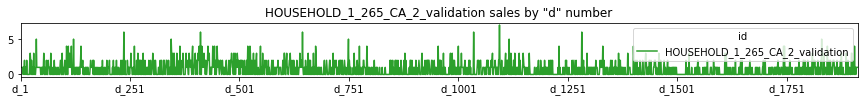

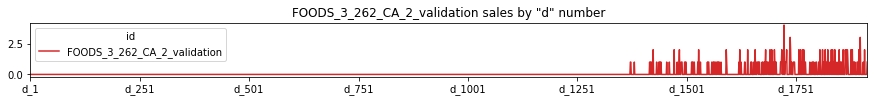

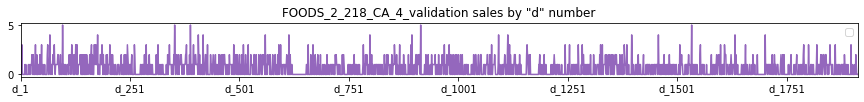

In [51]:
# построим как выглядит временной ряд продеж для произвольных 5 товаров

d_cols = [c for c in sales_df.columns if 'd_' in c] # sales data columns

group_of_items = sales_df['id'].values
num_to_select = 5
list_of_random_items = random.sample(list(group_of_items), num_to_select)

for item_id in list_of_random_items:
    sales_df.loc[sales_df['id'] == item_id].set_index('id')[d_cols].T\
    .plot(figsize=(15, 1), title='{} sales by "d" number'.format(item_id), 
         color=next(color_cycle))

plt.legend('')
plt.show()

Как видно, временные ряды продаж разных товаров очень разнородны. Помимо этого, у них есть 2 особенности: большой процент значений равных 0 и в целом дискретность ряда.

В связи с этим можно исследовать следующие 2 вещи: 

1. Есть ли в данных какой-то фактор, объясняющий такую большую долю 0 значений?

2. Насколько эти временные ряды вообще взаимосвязаны друг с другом? Можно ли выделить кластеры сильно скоррелированных временных рядов?

Для начала, посмотрим, какие факторы определяют поведение временного ряда.

Всего есть 3 категррии товаров: 'HOBBIES', 'HOUSEHOLD', 'FOODS'

3 типа штатов: 'CA' 'TX' 'WI'

10 магазинов: 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3'

7 типов департаментов: 'HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1', 'FOODS_2', 'FOODS_3'

Общая структура данных (взято из Competition Guide: https://mofc.unic.ac.cy/m5-competition/):

<img src="data_diagram.png">

Календарные мероприятия (30 штук): 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart', 'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster', 'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay', 'NBAFinalsStart', 'NBAFinalsEnd', "Father's day", 'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay', 'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay', 'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear', 'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'

Меропреятия делятся на 4 типа: 'Sporting', 'Cultural', 'National', 'Religious'


Существующие категории: ['HOBBIES' 'HOUSEHOLD' 'FOODS']


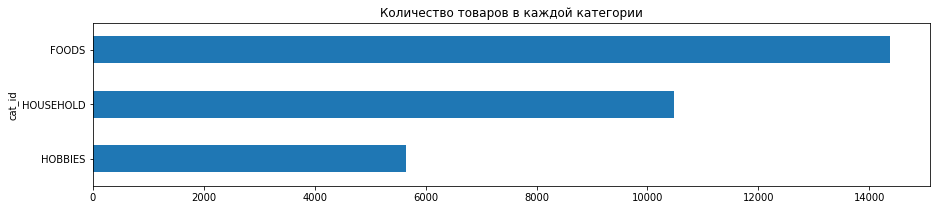

In [52]:
print('Существующие категории:', sales_df.cat_id.unique())

sales_df.groupby('cat_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 3), title='Количество товаров в каждой категории')
plt.show()

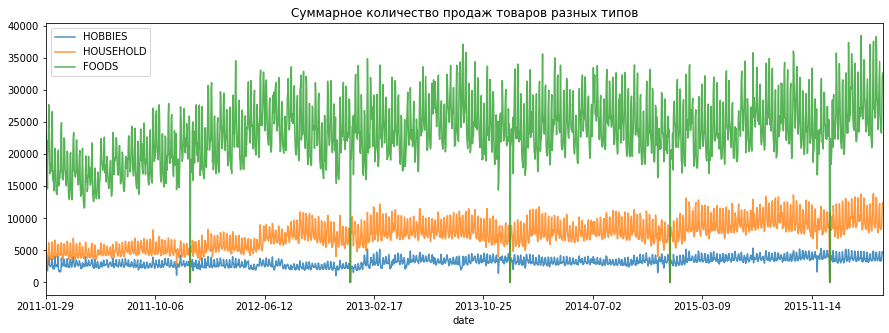

In [53]:
past_sales = sales_df.set_index('id')[d_cols].T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')


for i in sales_df['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5),
                                           alpha=0.8,
                                           title='Суммарное количество продаж товаров разных типов')
plt.legend(sales_df['cat_id'].unique())
plt.show()

In [54]:
sales_df


id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
5      HOBBIES_1_006_CA_1_validation  HOBBIES_1_006  HOBBIES_1  HOBBIES   
6      HOBBIES_1_007_CA_1_validation  HOBBIES_1_007  HOBBIES_1  HOBBIES   
7      HOBBIES_1_008_CA_1_validation  HOBBIES_1_008  HOBBIES_1  HOBBIES   
8      HOBBIES_1_009_CA_1_validation  HOBBIES_1_009  HOBBIES_1  HOBBIES   
9      HOBBIES_1_010_CA_1_validation  HOBBIES_1_010  HOBBIES_1  HOBBIES   
10     HOBBIES_1_011_CA_1_validation  HOBBIES_1_011  HOBBIES_1  HOBBIES   
11     HOBBIES_1_012_CA_1_validation  HOBBIES_1_012  HOBBIES_1  HOBBIES   
12     HOBBIES_1_013_CA_1_validation  HOBBIES_1_013  HOBBIES_1  HOBBIES   
13     HOBBIES_1_014_CA_1_validation  HOBBIES_1_014  HOBBIES_1  HOBBIES   
14     HOBBIES_1_015_CA_1_validation  HOBBIES_1_015  HOBBIES_1  HOBBIES   
15     HOBBIES_1_016_CA_1_validation  HOBBIES_1_016  HOBBIES_1  HOBBIES   
16     HOBBIES_1_017_CA_1_validation  HOBBIES_1_017  HOBBIES_1  HOBBIES   
17     HOBBIES_1_018_CA_1_validation  HOBBIES_1_018  HOBBIES_1  HOBBIES   
18     HOBBIES_1_019_CA_1_validation  HOBBIES_1_019  HOBBIES_1  HOBBIES   
19     HOBBIES_1_020_CA_1_validation  HOBBIES_1_020  HOBBIES_1  HOBBIES   
20     HOBBIES_1_021_CA_1_validation  HOBBIES_1_021  HOBBIES_1  HOBBIES   
21     HOBBIES_1_022_CA_1_validation  HOBBIES_1_022  HOBBIES_1  HOBBIES   
22     HOBBIES_1_023_CA_1_validation  HOBBIES_1_023  HOBBIES_1  HOBBIES   
23     HOBBIES_1_024_CA_1_validation  HOBBIES_1_024  HOBBIES_1  HOBBIES   
24     HOBBIES_1_025_CA_1_validation  HOBBIES_1_025  HOBBIES_1  HOBBIES   
25     HOBBIES_1_026_CA_1_validation  HOBBIES_1_026  HOBBIES_1  HOBBIES   
26     HOBBIES_1_027_CA_1_validation  HOBBIES_1_027  HOBBIES_1  HOBBIES   
27     HOBBIES_1_028_CA_1_validation  HOBBIES_1_028  HOBBIES_1  HOBBIES   
28     HOBBIES_1_029_CA_1_validation  HOBBIES_1_029  HOBBIES_1  HOBBIES   
29     HOBBIES_1_030_CA_1_validation  HOBBIES_1_030  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30460    FOODS_3_798_WI_3_validation    FOODS_3_798    FOODS_3    FOODS   
30461    FOODS_3_799_WI_3_validation    FOODS_3_799    FOODS_3    FOODS   
30462    FOODS_3_800_WI_3_validation    FOODS_3_800    FOODS_3    FOODS   
30463    FOODS_3_801_WI_3_validation    FOODS_3_801    FOODS_3    FOODS   
30464    FOODS_3_802_WI_3_validation    FOODS_3_802    FOODS_3    FOODS   
30465    FOODS_3_803_WI_3_validation    FOODS_3_803    FOODS_3    FOODS   
30466    FOODS_3_804_WI_3_validation    FOODS_3_804    FOODS_3    FOODS   
30467    FOODS_3_805_WI_3_validation    FOODS_3_805    FOODS_3    FOODS   
30468    FOODS_3_806_WI_3_validation    FOODS_3_806    FOODS_3    FOODS   
30469    FOODS_3_807_WI_3_validation    FOODS_3_807    FOODS_3    FOODS   
30470    FOODS_3_808_WI_3_validation    FOODS_3_808    FOODS_3    FOODS   
30471    FOODS_3_809_WI_3_validation    FOODS_3_809    FOODS_3    FOODS   
30472    FOODS_3_810_WI_3_validation    FOODS_3_810    FOODS_3    FOODS   
30473    FOODS_3_811_WI_3_validation    FOODS_3_811    FOODS_3    FOODS   
30474    FOODS_3_812_WI_3_validation    FOODS_3_812    FOODS_3    FOODS   
30475    FOODS_3_813_WI_3_validation    FOODS_3_813    FOODS_3    FOODS   
30476    FOODS_3_814_WI_3_validation    FOODS_3_814    FOODS_3    FOODS   
30477    FOODS_3_815_WI_3_validation    FOODS_3_815    FOODS_3    FOODS   
30478    FOODS_3_816_WI_3_validation    FOODS_3_816    FOODS_3    FOODS   
30479    FOODS_3_817_WI_3_validation    FOODS_3_817    FOODS_3    FOODS   
30480    FOODS_3_818_WI_3_validation    FOODS_3_818    FOODS_3    FOODS   
30481    FOODS_3_819_WI_3_validation    FOODS_3_819    FOOD

In [55]:
past_sales

HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   
2011-02-03                              0                              0   
2011-02-04                              0                              0   
2011-02-05                              0                              0   
2011-02-06                              0                              0   
2011-02-07                              0                              0   
2011-02-08                              0                              0   
2011-02-09                              0                              0   
2011-02-10                              0                              0   
2011-02-11                              0                              0   
2011-02-12                              0                              0   
2011-02-13                              0                              0   
2011-02-14                              0                              0   
2011-02-15                              0                              0   
2011-02-16                              0                              0   
2011-02-17                              0                              0   
2011-02-18                              0                              0   
2011-02-19                              0                              0   
2011-02-20                              0                              0   
2011-02-21                              0                              0   
2011-02-22                              0                              0   
2011-02-23                              0                              0   
2011-02-24                              0                              0   
2011-02-25                              0                              0   
2011-02-26                              0                              0   
2011-02-27                              0                              0   
...                                   ...                            ...   
2016-03-26                              1                              1   
2016-03-27                              1                              1   
2016-03-28                              1                              1   
2016-03-29                              0                              0   
2016-03-30                              0                              0   
2016-03-31                              0                              0   
2016-04-01                              0                              0   
2016-04-02                              0                              0   
2016-04-03                              1                              0   
2016-04-04                              0                              0   
2016-04-05                              4                              0   
2016-04-06                              2                              0   
2016-04-07                              3                              0   
2016-04-08                              0                              0   
2016-04-09                              1                              0   
2016-04-10                              2                              0   
2016-04-11                              0                              0   
2016-04-12                              0                              0   
2016-04-13                              0                              0   
2016-04-14                              1                   

В совокупных продажах по категориям явно прослеживаются, тренд, сезонность и периодичность.

Так же невооруженным глазом можно заметить явные выбросы в покупке еды в районе Рождества, что довольно естественно.

Типы штатов: ['CA' 'TX' 'WI']


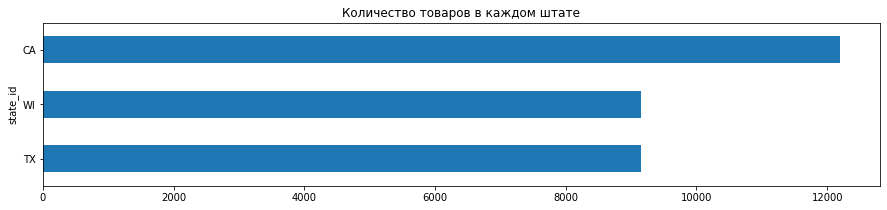

In [56]:
print('Типы штатов:', sales_df.state_id.unique())

sales_df.groupby('state_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 3), title='Количество товаров в каждом штате')
plt.show()

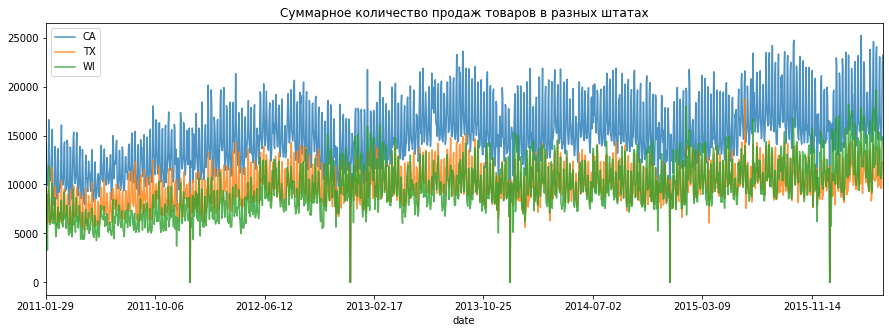

In [57]:
for i in sales_df['state_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).plot(figsize=(15, 5),
                                           alpha=0.8,
                                           title='Суммарное количество продаж товаров в разных штатах')
plt.legend(sales_df['state_id'].unique())
plt.show()

Типы штатов: ['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


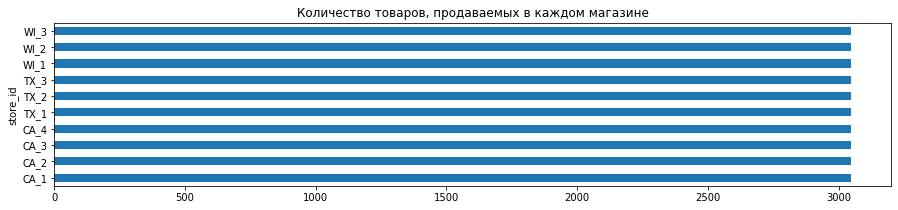

In [58]:
len(sales_df.store_id.unique())
print('Типы штатов:', sales_df.store_id.unique())

sales_df.groupby('store_id').count()['id'].sort_values() \
    .plot(kind='barh', figsize=(15, 3), title='Количество товаров, продаваемых в каждом магазине')
plt.show()

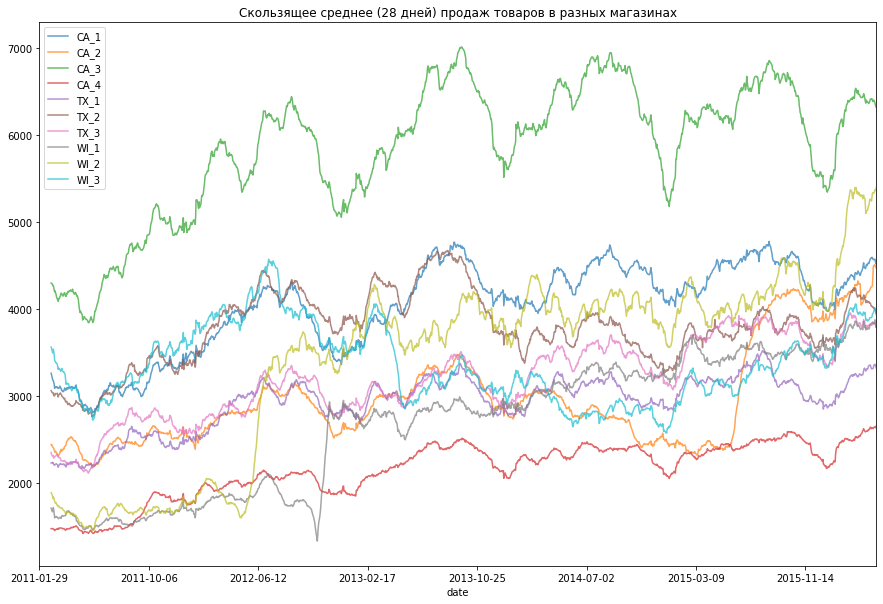

In [59]:
for i in sales_df['store_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis=1).rolling(28).mean().plot(figsize=(15, 10),
                                           alpha=0.7,
                                           title='Скользящее среднее (28 дней) продаж товаров в разных магазинах')
plt.legend(sales_df['store_id'].unique())
plt.show()

In [8]:
d_cols = [c for c in sales_df.columns if 'd_' in c]
past_sales = sales_df.set_index('id')[d_cols] \
    .T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1') \
    .set_index('date')
import plotly.graph_objects as go
fig = go.Figure()
store_list = sales_df['state_id'].unique()
for i, s in enumerate(store_list):
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean()
        fig.add_trace(go.Box(x=[s]*len(data), y=data, name=s))
    
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Cредние продажи в магазинах")

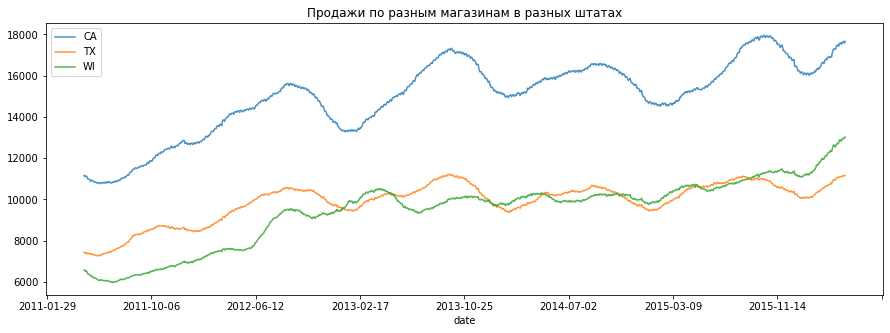

In [9]:
store_list = sales_df['state_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Продажи по разным магазинам в разных штатах')
plt.legend(store_list)
plt.show()

### Тепловая карта календаря

Как видно из предыдущих графиков, у нас есть явная периодичность в данных, давайте посмотрим, что с ними происходит в различные дни.

In [60]:
# ----------------------------------------------------------------------------
# Author:  Nicolas P. Rougier
# License: BSD
# ----------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from datetime import datetime
from dateutil.relativedelta import relativedelta


def calmap(ax, year, data):
    ax.tick_params('x', length=0, labelsize="medium", which='major')
    ax.tick_params('y', length=0, labelsize="x-small", which='major')

    # Month borders
    xticks, labels = [], []
    start = datetime(year,1,1).weekday()
    for month in range(1,13):
        first = datetime(year, month, 1)
        last = first + relativedelta(months=1, days=-1)

        y0 = first.weekday()
        y1 = last.weekday()
        x0 = (int(first.strftime("%j"))+start-1)//7
        x1 = (int(last.strftime("%j"))+start-1)//7

        P = [ (x0,   y0), (x0,    7),  (x1,   7),
              (x1,   y1+1), (x1+1,  y1+1), (x1+1, 0),
              (x0+1,  0), (x0+1,  y0) ]
        xticks.append(x0 +(x1-x0+1)/2)
        labels.append(first.strftime("%b"))
        poly = Polygon(P, edgecolor="black", facecolor="None",
                       linewidth=1, zorder=20, clip_on=False)
        ax.add_artist(poly)
    
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    ax.set_yticks(0.5 + np.arange(7))
    ax.set_yticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
    ax.set_title("{}".format(year), weight="semibold")
    
    # Clearing first and last day from the data
    valid = datetime(year, 1, 1).weekday()
    data[:valid,0] = np.nan
    valid = datetime(year, 12, 31).weekday()
    # data[:,x1+1:] = np.nan
    data[valid+1:,x1] = np.nan

    # Showing data
    ax.imshow(data, extent=[0,53,0,7], zorder=10, vmin=-1, vmax=1,
              cmap="RdYlBu_r", origin="lower", alpha=.75)

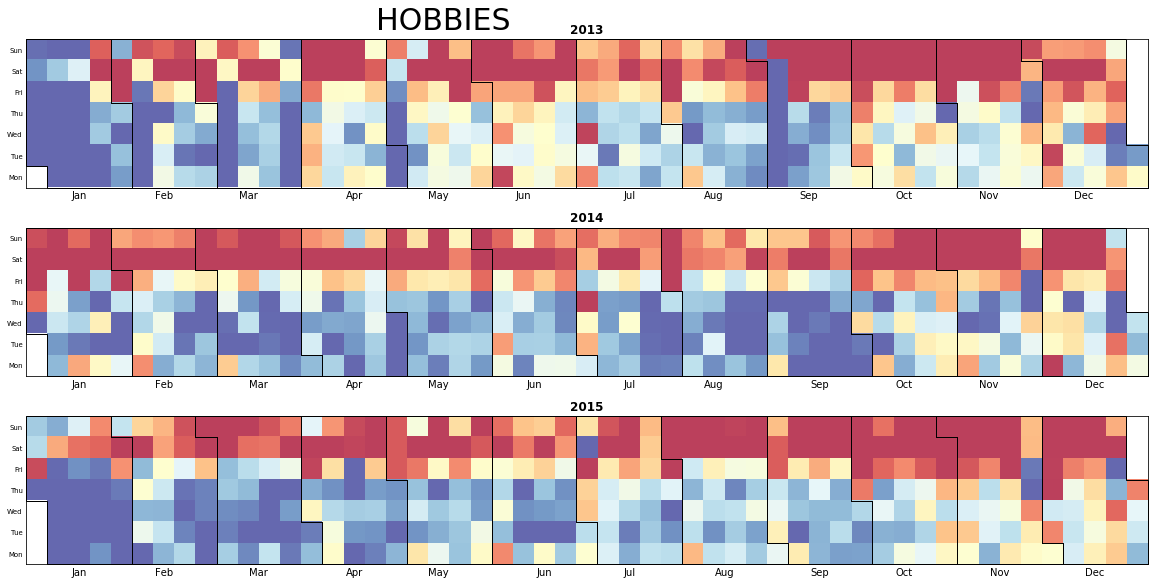

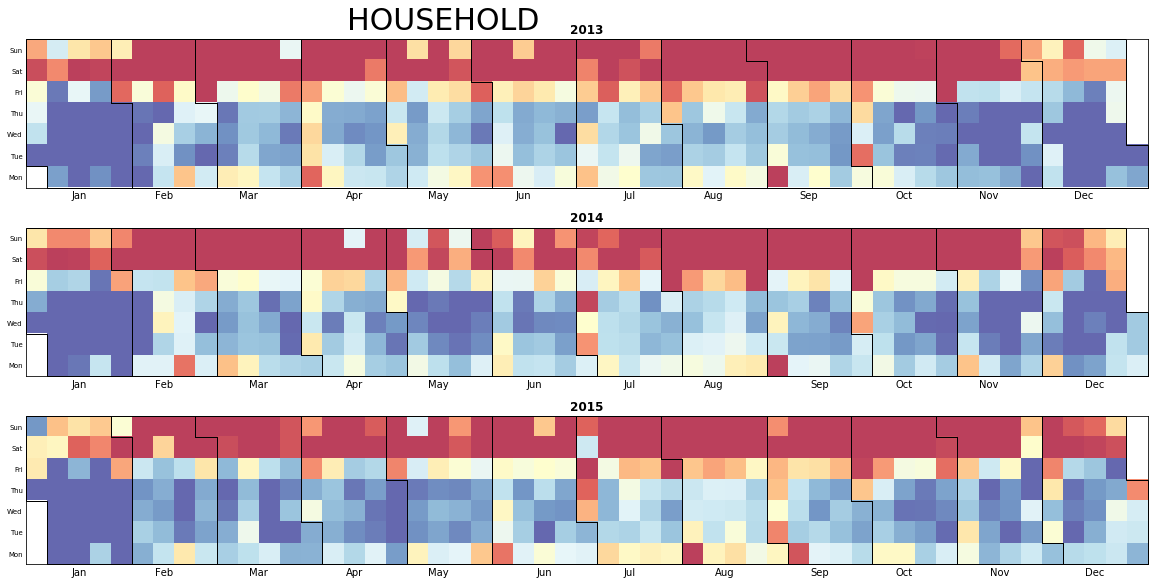

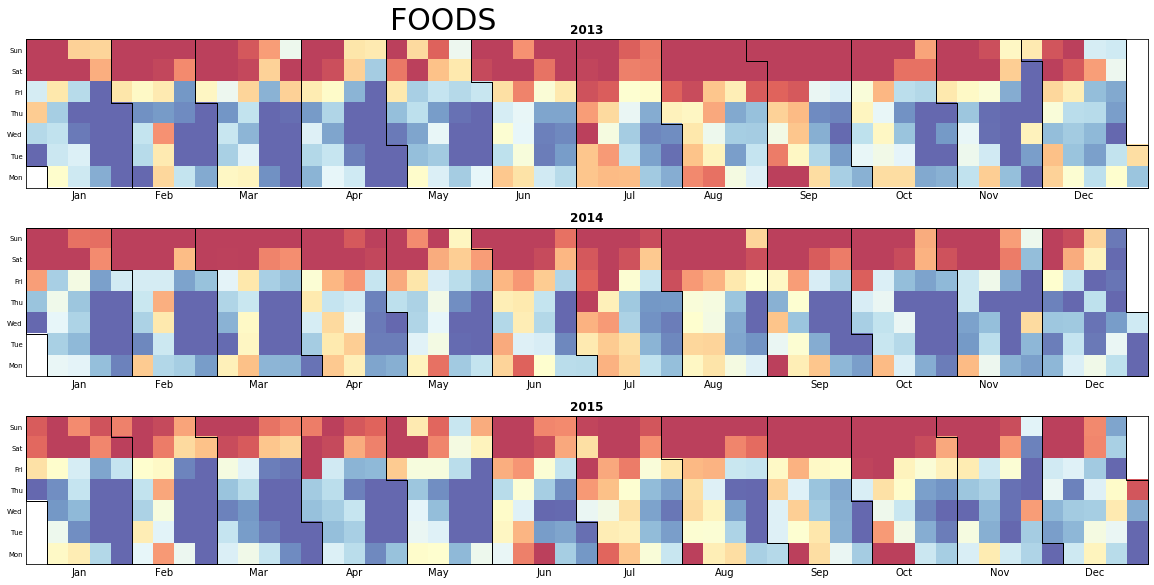

In [61]:
from sklearn.preprocessing import StandardScaler
sscale = StandardScaler()
past_sales.index = pd.to_datetime(past_sales.index)
for i in sales_df['cat_id'].unique():
    fig, axes = plt.subplots(3, 1, figsize=(20, 8))
    items_col = [c for c in past_sales.columns if i in c]
    sales2013 = past_sales.loc[past_sales.index.isin(pd.date_range('31-Dec-2012',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2013.values.reshape(-1, 1)))
    calmap(axes[0], 2013, vals.reshape(53,7).T)
    sales2014 = past_sales.loc[past_sales.index.isin(pd.date_range('30-Dec-2013',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2014.values.reshape(-1, 1)))
    calmap(axes[1], 2014, vals.reshape(53,7).T)
    sales2015 = past_sales.loc[past_sales.index.isin(pd.date_range('29-Dec-2014',
                                                                   periods=371))][items_col].mean(axis=1)
    vals = np.hstack(sscale.fit_transform(sales2015.values.reshape(-1, 1)))
    calmap(axes[2], 2015, vals.reshape(53,7).T)
    plt.suptitle(i, fontsize=30, x=0.4, y=1.01)
    plt.tight_layout()
    plt.show()

Наблюдения:

1) Высокая активность по покупкам в выходные, и низкая в начале недели

2) Начало и конец года сопровождаются спадом в активности (это можно объяснить тем, что люди тратят много денег на подарки)

3) В середине года (конец весны - лето) активность в нерабочие дни более высокая (период отпусков)

### Посмотрим как временные ряды скоррелированы между собой

In [65]:
hobbies_cols = [col for col in past_sales.columns if 'HOBBIES' in col]
foods_cols = [col for col in past_sales.columns if 'FOODS' in col]
household_cols = [col for col in past_sales.columns if 'HOUSEHOLD' in col]

In [66]:
past_sales

HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   
2011-02-03                              0                              0   
2011-02-04                              0                              0   
2011-02-05                              0                              0   
2011-02-06                              0                              0   
2011-02-07                              0                              0   
2011-02-08                              0                              0   
2011-02-09                              0                              0   
2011-02-10                              0                              0   
2011-02-11                              0                              0   
2011-02-12                              0                              0   
2011-02-13                              0                              0   
2011-02-14                              0                              0   
2011-02-15                              0                              0   
2011-02-16                              0                              0   
2011-02-17                              0                              0   
2011-02-18                              0                              0   
2011-02-19                              0                              0   
2011-02-20                              0                              0   
2011-02-21                              0                              0   
2011-02-22                              0                              0   
2011-02-23                              0                              0   
2011-02-24                              0                              0   
2011-02-25                              0                              0   
2011-02-26                              0                              0   
2011-02-27                              0                              0   
...                                   ...                            ...   
2016-03-26                              1                              1   
2016-03-27                              1                              1   
2016-03-28                              1                              1   
2016-03-29                              0                              0   
2016-03-30                              0                              0   
2016-03-31                              0                              0   
2016-04-01                              0                              0   
2016-04-02                              0                              0   
2016-04-03                              1                              0   
2016-04-04                              0                              0   
2016-04-05                              4                              0   
2016-04-06                              2                              0   
2016-04-07                              3                              0   
2016-04-08                              0                              0   
2016-04-09                              1                              0   
2016-04-10                              2                              0   
2016-04-11                              0                              0   
2016-04-12                              0                              0   
2016-04-13                              0                              0   
2016-04-14                              1                   

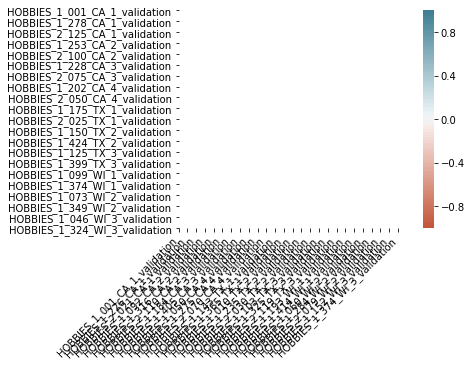

In [33]:
#  посмотрим корреляцию продаж товаров за все дни
corr = past_sales[hobbies_cols].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

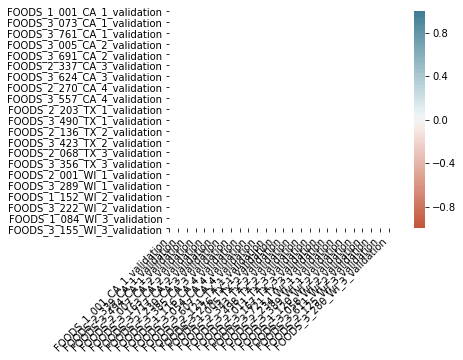

In [39]:
corr = past_sales[foods_cols].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

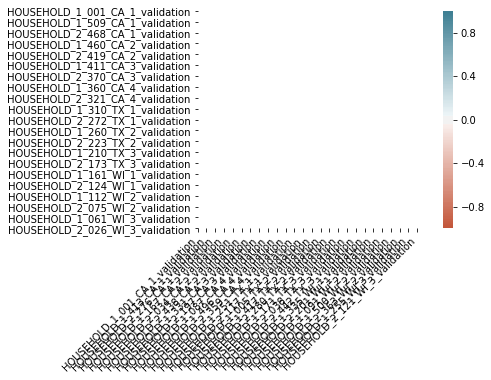

In [40]:
corr = past_sales[household_cols].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Как видно, продажи товаров очень слабо скоррелированы, тепловые карты белые.

Следовательно, товары имеет смысл рассматривать по отдельности

# Pipeline

Рассмотрим разные подходы к построению модели прогнозирования подаж:


In [67]:
# borrowed from: https://www.kaggle.com/dhananjay3/wrmsse-evaluator-with-extra-features
from typing import Union
from tqdm.auto import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [70]:
%time 

train_df = pd.read_csv('sales_train_evaluation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

#train_fold_df = train_df.iloc[:, :-28]
#valid_fold_df = train_df.iloc[:, -28:].copy()

train_fold_df = train_df.iloc[:, :-56]
valid_fold_df = train_df.iloc[:, -56: -28].copy()

train_fold_df1 = train_df.iloc[:, :-28]
test_fold_df = train_df.iloc[:, -28:].copy()

e_valid = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)
e_test = WRMSSEEvaluator(train_fold_df1, test_fold_df, calendar, prices)
# del train_fold_df, train_df, calendar, prices

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.15 µs


In [71]:
# Тестируем validation score: подаем случайные целочисленные значения от 0 до 3
test_preds = np.random.randint(4, size=test_fold_df.shape)
e_test.score(test_preds)

2.488915933602928

### Baseline solution

Мы будем двигаться от простого к сложному.
Для начала построим простое бейзлайн решение, чтобы в дальнейшем, отталкиваясь от него строить более сложные модели, добавлять новые признаки и оценивать их эффективность.

*Идея бейзлайн решения:* давайте для каждого товара прогнозировать константу продаж. Такую модель очень быстро построить, но она должна давать сравнительно неплохой результат. 

Так как метрика для каждого отдельного временного ряда: RMSSE, то оптимальной константой будет среднее. Мы можем варьировать период за который будет считаться среднее, чтобы наш прогноз меньше зависел от более старых продаж.

In [72]:
pred_mean = np.repeat(np.array([past_sales.mean().values]).T, repeats=28, axis=1)
    
e_valid.score(pred_mean)

1.5842923174352785

Как видно, значение уже лучше случайного предсказания. Попробуем пороварьировать период, за который мы производим усреднение.

WRMSSEE = 1.0883517247284709 при длине окна 101


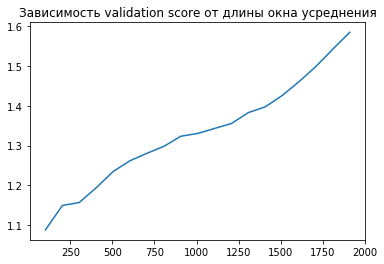

In [73]:
num_splits = 20

start_date_index_list = [int(i) for i in np.linspace(1, len(past_sales), 
                                                     num=num_splits)[:-1]]

score_list = []
for start_date_index in start_date_index_list:
    pred_mean = np.repeat(np.array([past_sales.values[start_date_index:,:].mean(axis=0)]).T, 
                          repeats=28, axis=1)
    score_list.append(e_valid.score(pred_mean))

window_len = [len(past_sales) - i for i in start_date_index_list]
plt.plot(window_len, score_list)
plt.title('Зависимость validation score от длины окна усреднения')

print('WRMSSEE = {} при длине окна {}'.format(min(score_list), window_len[np.array(score_list).argmin()]))

WRMSSE = 1.0643637860136472 при длине окна 29


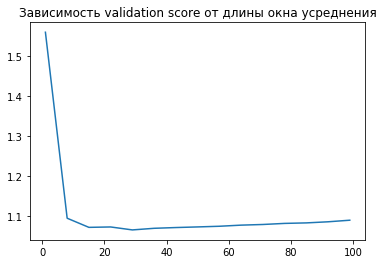

In [74]:
# Попробуем длину окна меньше 100

start_date_index_list = [len(past_sales) - int(i) for i in range(1, 100, 7)]

score_list = []
for start_date_index in start_date_index_list:
    pred_mean = np.repeat(np.array([past_sales.values[start_date_index:,:].mean(axis=0)]).T, 
                          repeats=28, axis=1)
    score_list.append(e_valid.score(pred_mean))
    
window_len = [len(past_sales) - i for i in start_date_index_list]
plt.plot(window_len, score_list)
plt.title('Зависимость validation score от длины окна усреднения')

print('WRMSSE = {} при длине окна {}'.format(min(score_list), window_len[np.array(score_list).argmin()]))

In [76]:
#считаем скор для тестовой выборки
pred_mean = np.repeat(np.array([past_sales.values[(len(past_sales)- 29):,:].mean(axis=0)]).T, 
                          repeats=28, axis=1)
    
e_test.score(pred_mean)

1.0786015014365025

### Linear model pipeline

Как показывает наш константный бейзлайн, он работает неплохо (1.07 CV WRMSSE, в то время, как лучшее публичное решение имеет 0.46 LB WRMSSE).
Попробуем развить идею. Графики суммарных продаж показыват, что в данных есть положительный тренд от года к году (это можно связать с экономическим ростом США). Поэтому вместо константы будем строить линейную модель по номеру дня, чтобы учесть этот тренд. 
Затем будем постепенно добавлять новые признаки к модели:
1. День недели (в данных наблюдается недельная цикличность)
2. День месяца (месячная цикличность - зарплатный период)
3. Особые дни 
4. Тип особого дня

In [78]:
from sklearn.linear_model import LinearRegression

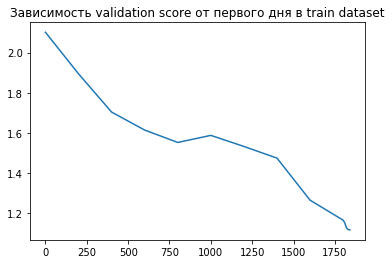

In [100]:
first_days = [i for i in range(0, 2000, 200)] + [i for i in range(1800, 1850, 10)]
scores = []
preds_test = []

for i in first_days:
    train_fold_df = train_df.T.iloc[6 + i:-56].reset_index().drop('index', axis=1)
    valid_fold_df = train_df.T.iloc[-56:-28].reset_index().drop('index', axis=1)
    test_fold_df = train_df.T.iloc[-28:].reset_index().drop('index', axis=1)
    
    X_train = np.array([train_fold_df.index.values]).T
    X_val = np.array([valid_fold_df.index.values]).T
    X_test = np.array([test_fold_df.index.values]).T
    
    pread_lr_val = []
    pred_lr_test = []
    
    for i in range(train_fold_df.shape[1]):
        y_train = train_fold_df.iloc[:, i].values
        y_val = valid_fold_df.iloc[:, i].values
        y_test = test_fold_df.iloc[:, i].values
        
        reg = LinearRegression().fit(X_train, y_train)
        pread_lr_val.append(reg.predict(X_val))
        pred_lr_test.append(reg.predict(X_test))
        
    pread_lr_np = np.array(pread_lr_val)
    pread_lr_np[pread_lr_np < 0] = 0
    
    pread_lr_np_test = np.array(pred_lr_test)
    pread_lr_np_test[pread_lr_np_test < 0] = 0
    preds_test.append(pread_lr_np_test)
    scores.append(e_valid.score(pread_lr_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [101]:
print(min(scores), first_days[np.array(scores).argmin()])

1.1171169561986178 1840


In [104]:
e_test.score(preds_test[np.array(scores).argmin()])

1.1267638426170767

Как видно, результат хуже константного бейзлайна. Добавим больше информации о днях

In [118]:
d_cols = [c for c in train_df.columns if 'd_' in c]

sales_history_df = train_df.set_index('id')[d_cols].T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')

calendar_df.date = pd.to_datetime(calendar_df.date)
full_df = pd.merge(sales_history_df, calendar_df, left_on='date', right_on='date')

In [119]:
full_df.month = event_df.month.astype(str)
category_columns = ['weekday', 'month', 'event_type_1', 'event_name_1']

data_category = pd.get_dummies(full_df[category_columns])
data_category.head()

weekday_Friday  weekday_Monday  weekday_Saturday  weekday_Sunday  \
0               0               0                 1               0   
1               0               0                 0               1   
2               0               1                 0               0   
3               0               0                 0               0   
4               0               0                 0               0   

   weekday_Thursday  weekday_Tuesday  weekday_Wednesday  month_1  month_10  \
0                 0                0                  0        1         0   
1                 0                0                  0        1         0   
2                 0                0                  0        1         0   
3                 0                1                  0        0         0   
4                 0                0                  1        0         0   

   month_11  ...  event_name_1_OrthodoxEaster  event_name_1_Pesach End  \
0         0  ...                            0                        0   
1         0  ...                            0                        0   
2         0  ...                            0                        0   
3         0  ...                            0                        0   
4         0  ...                            0                        0   

   event_name_1_PresidentsDay  event_name_1_Purim End  \
0                           0                       0   
1                           0                       0   
2                           0                       0   
3                           0                       0   
4                           0                       0   

   event_name_1_Ramadan starts  event_name_1_StPatricksDay  \
0                            0                           0   
1                            0                           0   
2                            0                           0   
3                            0                           0   
4                            0                           0   

   event_name_1_SuperBowl  event_name_1_Thanksgiving  \
0                       0                          0   
1                       0                          0   
2                       0                          0   
3                       0                          0   
4                       0                          0   

   event_name_1_ValentinesDay  event_name_1_VeteransDay  
0                           0                         0  
1                           0                         0  
2                           0                         0  
3                           0                         0  
4                           0                         0  

[5 rows x 55 columns]

In [120]:
full_df.drop(category_columns, axis=1, inplace=True)
full_df = pd.concat([full_df, data_category], axis=1)

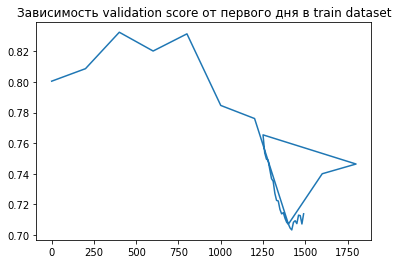

In [121]:
data_cols = [col for col in full_df.columns if 'weekday_' in col] + ['index']
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 2000, 200)] + [i for i in range(1250, 1500, 10)]
scores = []
preds_test = []

X_test, y_test = X[-28:], y[-28:]

# lgb_test = lgb.Dataset(X_test)
for i in first_days:
    X_train, X_val, y_train, y_val = X[i:-56], X[-56:-28], y[i:-56], y[-56:-28]

    pread_lr = []
    pread_lr_test = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_val_cur = y_val[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_val))
        pread_lr_test.append(reg.predict(X_test))
        
    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e_valid.score(pread_lr_np))
    
    pread_lr_np_test = np.array(pread_lr_test)
    pread_lr_np_test[pread_lr_np_test < 0] = 0
    preds_test.append(pread_lr_np_test)
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [122]:
print(min(scores), first_days[np.array(scores).argmin()])

0.7032605842676842 1420


In [123]:
e_test.score(preds_test[np.array(scores).argmin()])

0.7886596656664941

Добавление информации о дне недели существенно улучшило результат. Теперь добавим информацию о месяце и посмотрим, как он изменится

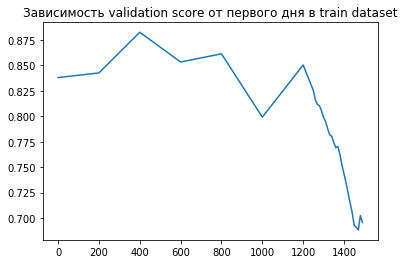

In [124]:
data_cols = [col for col in full_df.columns if 'weekday_' in col or 'month_' in col] + ['index']
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values

first_days = [i for i in range(0, 1250, 200)] + [i for i in range(1250, 1500, 10)]
scores = []
preds_test = []

X_test, y_test = X[-28:], y[-28:]

# lgb_test = lgb.Dataset(X_test)
for i in first_days:
    X_train, X_val, y_train, y_val = X[i:-56], X[-56:-28], y[i:-56], y[-56:-28]

    pread_lr = []
    pread_lr_test = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_val_cur = y_val[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_val))
        pread_lr_test.append(reg.predict(X_test))
        
    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e_valid.score(pread_lr_np))
    
    pread_lr_np_test = np.array(pread_lr_test)
    pread_lr_np_test[pread_lr_np_test < 0] = 0
    preds_test.append(pread_lr_np_test)
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [125]:
print(min(scores), first_days[np.array(scores).argmin()])

0.6884263482584505 1470


In [126]:
e_test.score(preds_test[np.array(scores).argmin()])

0.7447598028585685

Попробуем также использовать информацию о скидочной программе (snap_XX)

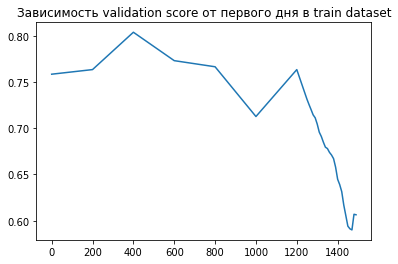

In [128]:
data_cols = [col for col in full_df.columns if 'weekday_' in col or 'month_' in col] + ['index'] + ['snap_CA', 'snap_TX', 'snap_WI'] 
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 1250, 200)] + [i for i in range(1250, 1500, 10)]
scores = []
preds_test = []

X_test, y_test = X[-28:], y[-28:]

# lgb_test = lgb.Dataset(X_test)
for i in first_days:
    X_train, X_val, y_train, y_val = X[i:-56], X[-56:-28], y[i:-56], y[-56:-28]

    pread_lr = []
    pread_lr_test = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_val_cur = y_val[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_val))
        pread_lr_test.append(reg.predict(X_test))
        
    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e_valid.score(pread_lr_np))
    
    pread_lr_np_test = np.array(pread_lr_test)
    pread_lr_np_test[pread_lr_np_test < 0] = 0
    preds_test.append(pread_lr_np_test)
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [129]:
print(min(scores), first_days[np.array(scores).argmin()])

0.5900522790664297 1470


In [130]:
e_test.score(preds_test[np.array(scores).argmin()])

0.668906302391066

Результат улучшился. Попробуем теперь добавить информацию о типе мероприятия.

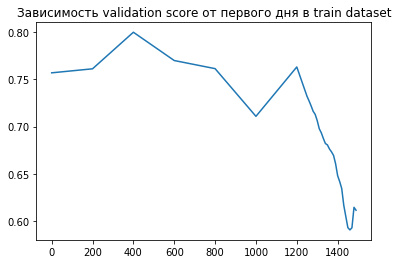

In [131]:
data_cols = [col for col in full_df.columns if 'weekday_' in col or 'month_' in col or 'event_type_1' in col]\
                    + ['index'] + ['snap_CA', 'snap_TX', 'snap_WI'] 
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [i for i in range(0, 1250, 200)] + [i for i in range(1250, 1500, 10)]
scores = []
preds_test = []

X_test, y_test = X[-28:], y[-28:]

# lgb_test = lgb.Dataset(X_test)
for i in first_days:
    X_train, X_val, y_train, y_val = X[i:-56], X[-56:-28], y[i:-56], y[-56:-28]

    pread_lr = []
    pread_lr_test = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_val_cur = y_val[:, i]

        reg = LinearRegression().fit(X_train, y_train_cur)
        pread_lr.append(reg.predict(X_val))
        pread_lr_test.append(reg.predict(X_test))
        
    pread_lr_np = np.array(pread_lr)
    pread_lr_np[pread_lr_np < 0] = 0

    scores.append(e_valid.score(pread_lr_np))
    
    pread_lr_np_test = np.array(pread_lr_test)
    pread_lr_np_test[pread_lr_np_test < 0] = 0
    preds_test.append(pread_lr_np_test)
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

In [132]:
print(min(scores), first_days[np.array(scores).argmin()])

0.5906220329711563 1460


In [133]:
e_test.score(preds_test[np.array(scores).argmin()])

0.6557867928752061

Как видно результат немного улучшился.

Проблема линейной регрессии заключается в том, что она ищет решение в очень узком классе данных: взвешенная линейная сумма признаков.
На практике данные могут иметь куда более сложную структуру.


# Exponential smoothing

Попробуем применить exponential smoothing. Для начала дополнительно исследуем данные на тренд, сезонность:

In [15]:
ids = np.unique(sales_df.id.values)
date_cols = [c for c in sales_df.columns if 'd_' in c]

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_df[d].values.sum())
from statsmodels.tsa.seasonal import seasonal_decompose
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_df[d].values.sum())
aggr_array = []
for d in date_cols:
    aggr_array.append(sales_df[d].values.sum())
    
date_range = calendar_df['date']
d_st = date_range.values[0]
d_end = date_range.values[1912]
date_range = pd.date_range(start=d_st, end=d_end)
daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)


series = daily_time_series_df['Sales']
result = seasonal_decompose(series, model='additive')
result_list = [result.trend, result.seasonal, result.resid, result.observed]

fig = make_subplots(rows=len(result_list), cols=1, subplot_titles=("Trend", "Seasonal", "Residual", "Observed"))

for i, res in enumerate(result_list):
    fig.add_trace(go.Scatter(x=date_range, y=res, showlegend=True, mode='lines'), row=i + 1, col=1)

                  
fig.update_layout(title="Seasonal Decomposition", height=1000, width=1000)
fig.update_xaxes(title_text="Date", row=4, col=1)
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)
fig.update_yaxes(title_text="Value", row=3, col=1)
fig.update_yaxes(title_text="Value", row=4, col=1)                
fig.show()

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=date_range[:140], y=result_list[1][:140], showlegend=True, mode='lines'))
fig.update_layout(title="Seasonal Component", xaxis_title="Date", yaxis_title="Units/Value", height=500, width=800)
fig.show()

Видем что присутсвует по недельная и по месячная сезонность.

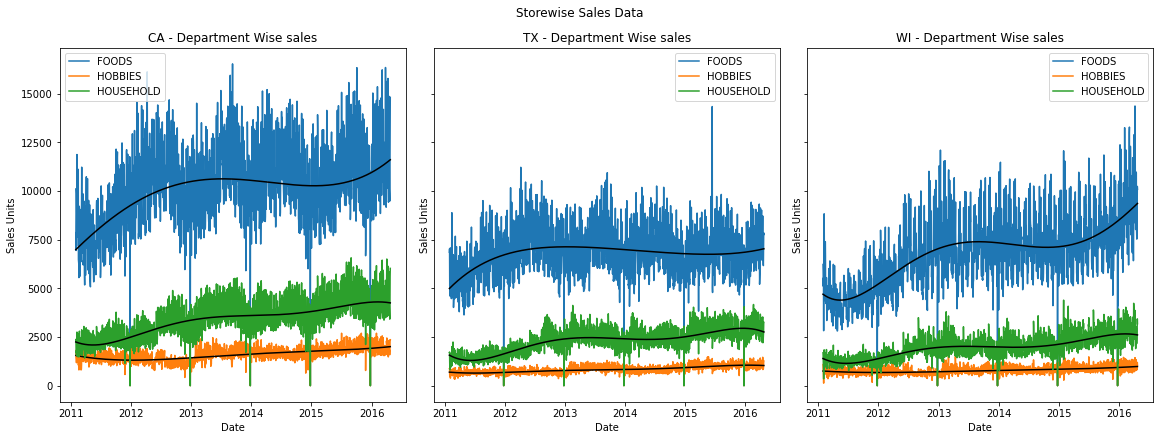

In [19]:
state_ids = np.unique(sales_df['state_id'].values)
dept_ids = sales_df['dept_id'].values
dept_category = []
for d_id in dept_ids:
    dept_category.append(d_id[:-2])
dept_category = np.array(dept_category)

sales_df['dept_cat'] = dept_category
dept_cat_ids = np.unique(dept_category)

# using matplotlib
fig, axs = plt.subplots(1, 3, figsize=(16, 6), sharey=True, constrained_layout=True)
fig.suptitle('Storewise Sales Data')

for i, st_id in enumerate(state_ids):
    state_wise_df = sales_df[sales_df['state_id'] == st_id]
    axs[i].set_title('%s - Department Wise sales' % st_id)
    axs[i].set(xlabel='Date', ylabel='Sales Units')
    for j, dp_cat_id in enumerate(dept_cat_ids):
        dept_wise_df = state_wise_df[state_wise_df['dept_cat'] == dp_cat_id]
        aggr_array = []
        for d in date_cols:
            aggr_array.append(dept_wise_df[d].values.sum())
        daily_time_series_df = pd.DataFrame(data=aggr_array, columns=['Sales'], index=date_range)
        
        X_values = range(len(daily_time_series_df))
        coeffs = np.polyfit(X_values, daily_time_series_df['Sales'].values, 5)
        poly_eqn = np.poly1d(coeffs)
        y_hat = poly_eqn(X_values)

        daily_time_series_df['sales_trend'] = y_hat
        axs[i].plot(daily_time_series_df.index, daily_time_series_df['Sales'].values, label='%s' % dp_cat_id)
        axs[i].plot(daily_time_series_df.index, daily_time_series_df['sales_trend'].values, color = 'black')
        axs[i].legend()
plt.show()

Перейдем к cамому exponential smoothing

In [24]:

train_dataset = sales_df[d_cols[-100:-30]]
val_dataset = sales_df[d_cols[-30:]]

KeyError: "['d_1937', 'd_1931', 'd_1914', 'd_1923', 'd_1917', 'd_1941', 'd_1921', 'd_1922', 'd_1935', 'd_1934', 'd_1939', 'd_1932', 'd_1927', 'd_1928', 'd_1915', 'd_1925', 'd_1919', 'd_1918', 'd_1924', 'd_1926', 'd_1930', 'd_1940', 'd_1920', 'd_1916', 'd_1929', 'd_1936', 'd_1938', 'd_1933'] not in index"

In [22]:
fig = make_subplots(rows=3, cols=1)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[0].values, marker=dict(color="dodgerblue"), showlegend=False,
               name="Original signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[0].values, mode='lines', marker=dict(color="darkorange"), showlegend=False,
               name="Denoised signal"),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[1].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[1].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70), mode='lines', y=train_dataset.loc[2].values, marker=dict(color="dodgerblue"), showlegend=False),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(x=np.arange(70, 100), y=val_dataset.loc[2].values, mode='lines', marker=dict(color="darkorange"), showlegend=False),
    row=3, col=1
)

fig.update_layout(height=1200, width=800, title_text="Train (blue) vs. Validation (orange) sales")
fig.show()

NameError: name 'val_dataset' is not defined

### LightGBM


Попробуем более продвинутый класс алгоритмов. Один из наиболее используемых методов для решения подобных задач - это градиентный бустинг.
Попробуем применить его здесь.



In [25]:
d_cols = [c for c in train_df.columns if 'd_' in c]

sales_history_df = train_df.set_index('id')[d_cols].T \
    .merge(calendar_df.set_index('d')['date'],
           left_index=True,
           right_index=True,
            validate='1:1').set_index('date')

calendar_df.date = pd.to_datetime(calendar_df.date)
sales_history_df.date = pd.to_datetime(sales_history_df.date)
full_df = pd.merge(sales_history_df, calendar_df, left_on='date', right_on='date')

AttributeError: 'DataFrame' object has no attribute 'date'

In [37]:
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder

lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.05,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 200,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# lgb_params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse'],
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': -1,
    "max_depth": 8, 
    'num_leaves': 63,
    "max_bin": 512,
    "num_iterations": 500,
    "n_estimators": 500
}

In [ ]:
full_df = full_df.apply(LabelEncoder().fit_transform)

In [ ]:
data_cols = ['index', 'wday', 'month', 'year', 'event_type_1', 'event_name_1', 
             'event_type_2', 'event_name_2', 'snap_CA', 'snap_TX', 'snap_WI']
target_cols = [col for col in full_df.columns if '_evaluation' in col]

X = full_df.reset_index()[data_cols].values
y = full_df[target_cols].values


first_days = [1180] #[i for i in range(0, 2000, 300)] + [i for i in range(1800, 1880, 30)]
scores = []

X_test, y_test = X[-28:], y[-28:]

# lgb_test = lgb.Dataset(X_test)
for i in first_days:
    X_train, X_val, y_train, y_val = X[i:-56], X[-56:-28], y[i:-56], y[-56:-28]
    


    pred_gbm = []

    for i in range(y_train.shape[1]):
        y_train_cur = y_train[:, i]
        y_val_cur = y_val[:, i]
        
        lgb_train = lgb.Dataset(X_train, y_train_cur)
        lgb_eval = lgb.Dataset(X_val, y_val_cur, reference=lgb_train)
        
        gbm = lgb.train(lgb_params,
                lgb_train,
                num_boost_round=10,
                valid_sets=lgb_train,  # eval training data
                feature_name=data_cols,
                categorical_feature=[1, 2, 3, 4, 5, 6, 7])
        
        
        pred_gbm.append(gbm.predict(X_test))

    pred_gbm_np = np.array(pred_gbm)
    pred_gbm_np[pred_gbm_np < 0] = 0

    scores.append(e.score(pred_gbm_np))
    
plt.title('Зависимость validation score от первого дня в train dataset')
plt.plot(first_days, scores)

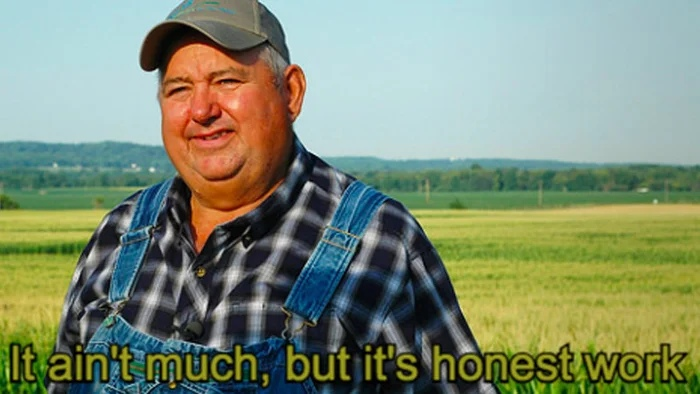